In [28]:
from ipynb.fs.full.Preprocessing import ReturnData,getData
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
sns.set()

In [29]:
def one_hot_encode(x):
    
    targets = []
    unique  = 4
    for t in x:
        ans = np.zeros(unique)
        ans[t] = 1
        targets.append(ans)
   
    return np.array(targets)
    


In [57]:
allData = ReturnData()

TrainX = allData[0][0]
TrainY = one_hot_encode(allData[0][1])
ValidationX = allData[1][0]
ValidationY = allData[1][1]
TestX = allData[2][0]
TestY = allData[2][1]

Initializing a Neural Network with 7 Nodes in the first layer, 8 Nodes in the second layer and 4 output nodes.

In [31]:
def init_layer(x,y):
    
    weight_matrix = np.random.rand(x,y)
    bias_vector  = np.ones((y,1))
    
    return [weight_matrix,bias_vector]

def init_network(neurons):
    length  = len(neurons)-1
    layers = []
    for i in range(length):
        x = neurons[i]
        y = neurons[i+1]
        layers.append(init_layer(x,y))
        
    return layers

my_network = init_network([7,8,4])
initial = np.copy(my_network)
network1 = np.copy(my_network)
network2 = np.copy(my_network)

/home/yaseen/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:793: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


We will be using a sigmoid as the activation function for the first layer and a softmax as the activation in the final layer.

In [32]:
def sigmoid(x):
    
    y = 1/(1+np.exp(-x))
    return y

def softmax(x):
    
    e = np.exp(x)
    probs = e/np.sum(e)
    return probs

def Max(x):
    
    result = np.where(x == np.amax(x))[0]
    
    return result[0]



In [33]:
def ForwardPropogation(data,Network):
    
    Layers = len(Network)
    
    avalues = []
    
    for i in range(Layers):
        
        if(i==0):
            a = data
            avalues.append(np.insert(a,0,np.ones(1),axis=0))
            Θ = Network[i][0]
            z = sigmoid(np.dot(np.transpose(Θ),avalues[i]).astype('float'))
            avalues.append(z)
            
        else:
            a = avalues[i]
            Θ = Network[i][0]
            z = softmax(np.dot(np.transpose(Θ),a))
            avalues.append(z)
    
    return avalues

FP = ForwardPropogation(TrainX[0],my_network)

In [34]:
def FinalError(Predicted,Actual):
    
    return Predicted - Actual

FE = FinalError(FP[len(FP)-1],TrainY[0])

In [35]:
def LayerError(activations,FinalError,Network):
    
    Layers = len(Network)
    Errors = []
    for i in range(Layers-1,0,-1):
        Θ = Network[i][0]
        dg = activations[i]*(1-activations[i])
        a = np.matmul(Θ,np.transpose(FinalError))
        δ = a*np.transpose(dg)
        Errors.append(δ)
    Errors.append(FinalError)
    
    return Errors
LE = LayerError(FP,FE,my_network)

In [36]:
def Gradient(Errors,activations):
    
    gradients = []
    
    for i in range(len(activations)-1):
        δ = np.reshape(Errors[i],(len(Errors[i]),1))
        a = np.reshape(activations[i],(len(activations[i]),1))
        Δ = np.matmul(a,np.transpose(δ))
        gradients.append(Δ)
        
    return gradients 
GR = Gradient(LE,FP)

In [37]:
def weightUpdate(Network,Gradients,α):
    
    Layers = len(Network)
    weights = []
    for i in range(Layers):
        Θ = np.copy(Network[i][0])
        Δ = Gradients[i] ##(7x8)
        step = α*Δ
        Θ = np.subtract(Θ,step)
        weights.append([Network[i][0],Θ])
        Network[i][0] = Θ
    
    return weights

WU = weightUpdate(my_network,GR,0.01)


In [38]:
def TrainModel(Network,data,Targets,α,epochs,ϵ):
    start = time.time()
    c1 = 1
    c2 = 1
    it = 0
    length = len(data)
    while(epochs>0 and (c1 > ϵ or c2 > ϵ)):
        
        for i in range(length):
            d = data[i]
            forward_propogation = ForwardPropogation(d,Network)
            final_errors = FinalError(forward_propogation[len(forward_propogation)-1],Targets[i])
            layer_errors = LayerError(forward_propogation,final_errors,Network)
            gradients = Gradient(layer_errors,forward_propogation)
            weights = weightUpdate(Network,gradients,α)
            
        c1 = np.linalg.norm(weights[0][1]-weights[0][0])
        c2 = np.linalg.norm(weights[1][1]-weights[1][0])
        epochs-=1
    end = time.time()
    totaltime = end - start
    return weights,totaltime

newWeights = TrainModel(my_network,TrainX,TrainY,0.1,1000,0.05)

In [39]:
def Predict(Network,Data):
    
    predicted = []
    for d in Data:
        predicted.append(Max(ForwardPropogation(d,Network)[2]))

    return predicted
        
PR = Predict(my_network,ValidationX)



In [40]:
def ConfusionMatrix(Predicted,Actual,Unique):
    
    confusion_matrix = np.zeros((Unique,Unique))
    length = len(Actual)
    k = 4
    if(type(Actual[0]) == int ):
        k = 0
    for i in range(length):
        p = Predicted[i]
        if(k>0):
            a = np.where(Actual[i] == 1)[0][0]
        else:
            a = Actual[i]
        confusion_matrix[a][p]+=1
        
    accuracy = np.sum(np.diag(confusion_matrix))/np.sum(confusion_matrix)
    
    return confusion_matrix,accuracy

In [41]:
ITP = Predict(initial,TrainX)
ICM = ConfusionMatrix(ITP,TrainY,4)
print("The Confusion Matrix prior to training is:\n",ICM[0])
print("The Accuracy prior to training is:",ICM[1]*100,"% \n")


The Confusion Matrix prior to training is:
 [[  0.   0. 711.   0.]
 [  0.   0. 239.   0.]
 [  0.   0.  44.   0.]
 [  0.   0.  43.   0.]]
The Accuracy prior to training is: 4.243008678881389 % 



In [42]:
ATP = Predict(my_network,TrainX)
ACM = ConfusionMatrix(ATP,TrainY,4)
print("The Confusion Matrix after to training is:\n",ACM[0])
print("The Accuracy after training is:",ACM[1]*100,"%\n")
print("The time taken to Train the model is:",newWeights[1])

The Confusion Matrix after to training is:
 [[711.   0.   0.   0.]
 [239.   0.   0.   0.]
 [ 44.   0.   0.   0.]
 [ 43.   0.   0.   0.]]
The Accuracy after training is: 68.56316297010608 %

The time taken to Train the model is: 0.091033935546875


In [43]:
V1P = Predict(my_network,ValidationX)
V1CM = ConfusionMatrix(V1P,ValidationY,4)

print("The Confusion Matrix for the Validation data is:\n",V1CM[0])
print("The Accuracy is:",V1CM[1]*100,"%")

The Confusion Matrix for the Validation data is:
 [[253.   0.   0.   0.]
 [ 71.   0.   0.   0.]
 [ 16.   0.   0.   0.]
 [  6.   0.   0.   0.]]
The Accuracy is: 73.121387283237 %


In [44]:
t1 = TrainModel(network1,TrainX,TrainY,0.0001,1000,0.05)
V2P = Predict(network1,ValidationX)
V2CM = ConfusionMatrix(V2P,ValidationY,4)

print("The Confusion Matrix for the Validation data is:\n",V2CM[0])
print("The Accuracy is:",V2CM[1]*100,"%\n")
print("The time taken to Train the model is:",t1[1])

The Confusion Matrix for the Validation data is:
 [[  0.   0. 253.   0.]
 [  0.   0.  71.   0.]
 [  0.   0.  16.   0.]
 [  0.   0.   6.   0.]]
The Accuracy is: 4.624277456647398 %

The time taken to Train the model is: 0.09947776794433594


In [45]:
t2 = TrainModel(network2,TrainX,TrainY,0.1,1000,0.000000005)
V3P = Predict(network2,ValidationX)
V3CM = ConfusionMatrix(V3P,ValidationY,4)

print("The Confusion Matrix for the Validation data is:\n",V3CM[0])
print("The Accuracy is:",V3CM[1]*100,"%\n")
print("The time taken to Train the model is:",t2[1])

The Confusion Matrix for the Validation data is:
 [[246.   7.   0.   0.]
 [  8.  63.   0.   0.]
 [  0.   0.  14.   2.]
 [  0.   1.   0.   5.]]
The Accuracy is: 94.79768786127167 %

The time taken to Train the model is: 90.88841032981873


In [46]:
network3 = init_network([7,10,4])
t3 = TrainModel(network3,TrainX,TrainY,0.1,1000,0.000000005)
V4P = Predict(network3,ValidationX)
V4CM = ConfusionMatrix(V4P,ValidationY,4)

print("The Confusion Matrix for the Validation data is:\n",V4CM[0])
print("The Accuracy is:",V4CM[1]*100,"%\n")
print("The time taken to Train the model is:",t3[1])

The Confusion Matrix for the Validation data is:
 [[251.   2.   0.   0.]
 [ 13.  57.   1.   0.]
 [  0.   0.  16.   0.]
 [  0.   0.   0.   6.]]
The Accuracy is: 95.37572254335261 %

The time taken to Train the model is: 31.498767375946045


In [59]:
network4 = init_network([7,9,4])
t4 = TrainModel(network4,TrainX,TrainY,0.1,1000,0.000000005)
V5P = Predict(network4,ValidationX)
V5CM = ConfusionMatrix(V5P,ValidationY,4)

print("The Confusion Matrix for the Validation data is:\n",V5CM[0])
print("The Accuracy is:",V5CM[1]*100,"%\n")
print("The time taken to Train the model is:",t4[1])

The Confusion Matrix for the Validation data is:
 [[227.   7.   1.   0.]
 [ 11.  66.   2.   2.]
 [  0.   0.  13.   0.]
 [  0.   0.   0.  17.]]
The Accuracy is: 93.35260115606935 %

The time taken to Train the model is: 92.47370982170105


Clearly the best network is network4 with 9 nodes in the hidden layer, a learning rate if 0.1 and threshold of 0.000000005

In [60]:
TestP = Predict(network4,TestX)
TestCM = ConfusionMatrix(TestP,TestY,4)
print("The Confusion Matrix for the Test data is:\n",TestCM[0])
print("The precision score is: ",metrics.precision_score(TestY.astype('int'),TestP,average=None),"\n")
print("The recall score is:",metrics.recall_score(TestY.astype('int'),TestP,average=None),"\n")
print("The Accuracy is:",TestCM[1]*100,"%\n")

The Confusion Matrix for the Test data is:
 [[235.  12.   0.   0.]
 [  4.  69.   0.   0.]
 [  0.   0.  12.   0.]
 [  0.   2.   0.  11.]]
The precision score is:  [0.9832636 0.8313253 1.        1.       ] 

The recall score is: [0.951417   0.94520548 1.         0.84615385] 

The Accuracy is: 94.78260869565217 %



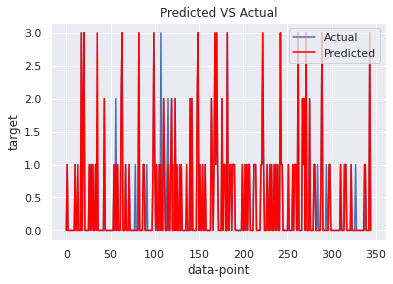

In [56]:
plt.plot(np.arange(len(TestY)),TestY,label = "Actual")
plt.plot(np.arange(len(TestY)),TestP,label = "Predicted",color="red")
plt.xlabel("data-point")
plt.ylabel("target")
plt.title("Predicted VS Actual")
plt.legend(loc = 'upper right')
plt.show()
plt.close()